In [1]:
from lib.models.deepsdf import DeepSDF
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.rendering.utils import normalize

def R_x(theta: float):
    _theta = np.deg2rad(theta)
    return np.array([
        [1, 0, 0],
        [0, np.cos(_theta), -np.sin(_theta)],
        [0, np.sin(_theta), np.cos(_theta)],
    ])

def R_y(theta: float):
    _theta = np.deg2rad(theta)
    return np.array([
        [np.cos(_theta), 0, np.sin(_theta)],
        [0, 1, 0],
        [-np.sin(_theta), 0, np.cos(_theta)],
    ])

def R_z(theta: float):
    _theta = np.deg2rad(theta)
    return np.array([
        [np.cos(_theta), -np.sin(_theta), 0],
        [np.sin(_theta), np.cos(_theta), 0],
        [0, 0, 1],
    ])


def R_azim_elev(azim: float = 0.0, elev: float = 0.0):
    return R_y(azim) @ R_x(elev)

class Object3D:
    def signed_distance(self):
        raise NotImplementedError()

    def normal(self):
        raise NotImplementedError()


class SDF(Object3D):
    def __init__(self, ckpt_path=str, obj_idx: int = 0):
        self.model = DeepSDF.load_from_checkpoint(ckpt_path).eval()
        self.lat_vec = self.model.lat_vecs(torch.tensor(obj_idx))

    def signed_distance(self, point):
        x = (
            torch.tensor(point, dtype=torch.float32)[None, None],
            self.lat_vec[None, None],
        )
        return self.model.predict(x).squeeze().item()

    def signed_distance_batch(self, points):
        x = (
            torch.tensor(points, dtype=torch.float32)[None, None],
            self.lat_vec[None, None],
        )
        return self.model.predict(x).squeeze().item()


class Circle(Object3D):
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def signed_distance(self, point):
        center = self.center
        radius = self.radius
        surface_point = normalize(point - center) * radius
        dist = np.linalg.norm(surface_point - point)
        if np.linalg.norm(surface_point - center) > np.linalg.norm(point - center):
            dist *= -1
        return dist

    def normal(self, point):
        return normalize(self.center - point)

class Camera:
    def __init__(
        self,
        dist: int = 1,
        elev: float = 0.0,
        azim: float = 0.0,
        image_size: int = 64,
    ):
        ...

    def canvas_pixel(self, xi, yi):
        _x = self.xs[xi] * self._width_vec
        _y = self.ys[yi] * self._height_vec
        return self.center_image_plane + _x + _y

    @property
    def empty_canvas(self):
        return np.full((self.resolution, self.resolution, 3), 0)

    @property
    def canvas(self):
        zs = np.full((self.resolution, self.resolution), self.z)
        grid = np.meshgrid(self.xs, self.ys)
        return np.stack([grid[0], grid[1], zs], axis=-1)

sdf_obj = SDF(ckpt_path="/Users/robinborth/Code/sketch2shape/logs/last.ckpt", obj_idx=34)
circle_obj = Circle(center=np.array([0, 0, 0]), radius=1)
camera = Camera(elev=0, azim=0, dist=1, image_size=256)

/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.1.0
/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


/opt/homebrew/Caskroom/miniforge/base/envs/sketch2shape/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


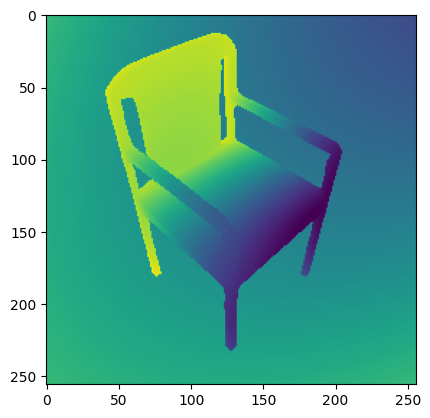

In [2]:
max_steps = 50
dist = 1.2
focal_length = 1 
resolution = 256
azim=-45
elev=45
R = torch.tensor(R_azim_elev(azim=azim, elev=elev), dtype=torch.float32)

xs = torch.linspace(0.5, -0.5, resolution)
ys = torch.linspace(0.5, -0.5, resolution)
zs = torch.full((resolution, resolution), -(dist))
grid = torch.meshgrid(xs, ys)
canvas = torch.stack([grid[0], grid[1], zs], axis=-1).view(-1, 3)
camera_point = torch.tensor([0, 0, -(dist + focal_length)], dtype=torch.float32)

transformed_canvas = (R @ canvas.T).T
transformed_camera_point = (R @ camera_point)
rays = (transformed_canvas - transformed_camera_point)
normalized_rays = rays / torch.linalg.norm(rays, axis=-1)[..., None]
depth = torch.zeros((rays.shape[0],))
sd = torch.zeros((rays.shape[0],))
image = transformed_canvas.detach().clone()
lat_vec = sdf_obj.lat_vec[None].expand((rays.shape[0], -1))
mask = torch.full((lat_vec.shape[0],), True, dtype=torch.bool)
void_mask = torch.full((lat_vec.shape[0],), True, dtype=torch.bool)
for _ in range(max_steps):
    point = transformed_canvas + depth[..., None] * rays
    with torch.no_grad():
        _sd = sdf_obj.model.predict((point[mask], lat_vec[mask])).squeeze()
    depth[mask] += _sd * 0.7
    sd[mask] = _sd

    surface_idx = torch.where(sd < 1e-03)
    void_idx = torch.where(depth > 2)
    mask[void_idx] = False
    void_mask[void_idx] = False 
    mask[surface_idx] = False
    image[surface_idx] = point[surface_idx]
    
img = torch.linalg.norm((image - canvas), dim=-1).view(resolution, resolution).T
plt.imshow(img)

In [3]:
xyz = torch.autograd.Variable(image, requires_grad=True)
sd = sdf_obj.model.predict((xyz, lat_vec)).squeeze()
loss = sd.mean()
loss.backward()
normals = xyz.grad 

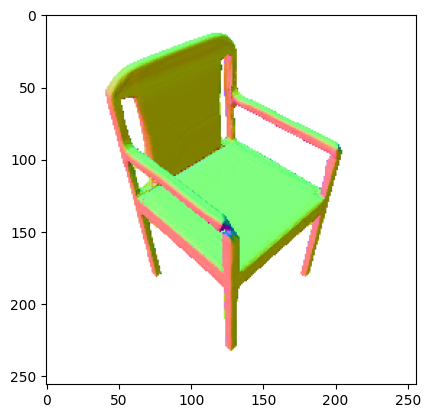

In [4]:
img = ((normalize(normals) + 1) / 2)
img[~void_mask] = 1
img = img.view(resolution, resolution, 3).permute(1, 0, 2)
plt.imshow(img)